# Fairness 

In [305]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import plot_confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [38]:
%%capture
%run ./german.ipynb

In [336]:
NEW = False

# Les femmes sont discriminées

## Définition de la *fairness*

([source](https://en.wikipedia.org/wiki/Fairness_(machine_learning)))

On appelle biais algorithmique une erreur systématique et reproductible d'un système informatique qui conduit les sorties de ce système à favoriser un groupe d'individus plutôt qu'un autre. Cette notion est déjà abordée par Joseph Weizenbaum en 1967 qui décrit les programmes informatiques de l'époque comme des outils mimiquant le raisonnement humain pour résoudre des problèmes. Il dit dans *Computer Power and Human Reason* que les règles suivies par les programmes internalisent la vision du monde de leur créateur, ce qui inclut leurs biais et leurs attentes. Cela concerne également les algorithmes qui apprennent par eux-même puisque, s’il existe une base de données, celle-ci est confectionnée par des hommes, s’il existe des règles (ex apprentissage par renforcement), ces dernières ont été fixées par les programmeurs. Les algorithmes d’apprentissage sont donc eux aussi concernés par les biais algorithmiques.

Le principe de *fairness* en apprentissage statistique correspond aux différentes manières de corriger ou de mitiger ce problème de biais algorithmique. S’il est difficile de donner une définition universelle de la *fairness*, de manière générale on considère qu'un résultat est équitable s'il est indépendant d'un certain jeu de variables appelées *variables sensibles*. Pour une personne les variables sensibles correspondent classiquement aux attributs comme le sexe, l'ethnicité, l'orientation sexuelle, et tout autre caractéristique sur laquelle la discrimination est interdite.

Bien que le problème de biais algorithmique soient connus depuis les années 70, les recherches en matière de *fairness* sont très récentes. Les publications les plus importantes datent ainsi seulement de 2018. (citer des papier ?)

## Définition mathématique

Bien que la définition littéraire de *fairness* soit intuitive, il est nécessaire de faire des hypothèses pour mettre en place une définition mathématique. Il existe ainsi différentes définitions de la *fairness* en fonction des hypothèses retenues. De manière générale, ces définitions visent à minimiser la déviation (ou le biais statistique) d'une ou plusieurs *métriques de parité*, cela pour tous les individus ou tous les groupes d'individus.
La définition varie en fonction de la métrique retenue et il existe un grand nombre de métriques de parités comme on peut le voir sur ([liste](https://developers.google.com/machine-learning/glossary/fairness)). Certains outils existent pour choisir une métrique plutôt qu'une autre en fonction du rôle qu'aura le modèle statistique. Par exemple [*Aquiteas*](https://github.com/dssg/aequitas), qui est un ensemble d’outils de *fairness* développés par le centre *data science and public policy* de l'université de Chicago, propose l'arbre de décision suivant :

![](data/imgs/Fairness-Full-Tree.png)


Nous allons maintenant donner trois définitions de la *fairness* en utilisant trois métriques distinctes. On utilise dans ce qui suit les notations suivantes :
 - $Y$ : la caractéristique binaire de sortie
 - $X$ : le vecteur de caractéristique d'entrée sans la caractéristique sensible
 - $S$ : la caractéristique sensible
 - $\hat{Y}$ : la prédiction de la caractéristique de sortie
 
 
**Définition 1 : *equalized odds***

On dit que $\hat{Y}$ satisfait l'égalité des chances par rapport à $S$ et $Y$ si :
$$
P(\hat{Y}=1 \mid S=0, Y=y)=P(\hat{Y}=1 \mid S=1, Y=y) ; \quad y=0,1
$$
Autrement dit, $\hat{Y}$ est indépendant de $S$ conditionnellement à $Y$.

**Définition 2 : *demographic parity***

On dit que $\hat{Y}$ satisfait la parité démographique par rapport à $S$ si :
$$
P(\hat{Y}=1 \mid S=0)=P(\hat{Y}=1 \mid S=1)
$$
Autrement dit, $\hat{Y}$ est indépendant de S.

**Définition 3 : *counterfactual fairness***

On dit que $\hat{Y}$ satisfait l'équité contrefactuelle par rapport à $S$ et $X$ si :
$$
P(\hat{Y}=1 \mid S=0, X=x)=P(\hat{Y}=1 \mid S=1, X=x)
$$
Autrement dit, $\hat{Y}$ est indépendant de $S$ conditionnellement à $X$.

L'égalité des chance et la parité démographique sont des métriques de parité de groupe (*group fairness*), on cherche à avoir le même traitement pour des groupes de personnes définies par leurs variables sensibles $S$. Alors que l'équité contrefactuelle est une métrique de parité individuelle (*individual fairness*), on cherche à fournir un traitement similaire à des personnes similaires peu importe leurs variables sensibles.

Il est tout à fait possible d'avoir une fusion entre *group fairness* et *individual fairness*, produisant alors un *subgroup fairness*.

## Application de la *fairness*

Les problèmes de biais algorithmiques peuvent survenir des données ou du modèle. Pour cela, on catégorise les méthodes d'implémentation des solutions de *fairness* en trois parties :
 - pre-processing : ces méthodes qui ne dépendent pas du modèle, tendent à mitiger les problèmes de *fairness* en modifiant les données elles-même. Il s'agit souvent de transformer une ou plusieurs caractéristiques ou de changer la représentation des groupes.
 - in-processing : ces méthodes incorporent dans le processus d'entraînement les métriques que l'on cherche à minimiser.  
 - post-processing : ces méthodes n'ont pas besoin d'un accès au modèle d'entraînement et traitent le problème de *fairness* directement sur les prédictions et non sur la base de données d'entraînement comme le font les méthodes in-processing.  

Dans la suite, nous allons illustrer les différents biais qui peuvent exister dans notre modèle de prédiction en prenant comme variable sensible le sexe de l'individu. Nous verrons ensuite l'implémentation de méthodes *pre-processing*, *post-processing* et *in-processing* pour résoudre ces biais.


# Mise en situation et implémentations

## Utilisation de la matrice de confusion

La majorité des mesures de partialité sont basées sur la matrice de confusion. Elle comporte quatre classes :
 - Vrai positif (VP) : la vraie classe est 1 et la classe prédite est 1
 - Faux positif (FP) : la vraie classe est 0 et la classe prédite est 1
 - Vrai négatif (VN) : la vraie classe est 0 et la classe prédite est 0
 - Faux négatif (FN) : la vraie classe est 1 et la classe prédite est 0

Les métriques de partialité sont calculées à partir des quatre valeurs associées à ces quatre classes pour des groupes de personnes partageants des caractéristiques communes ( ex: sex, ethnicité).


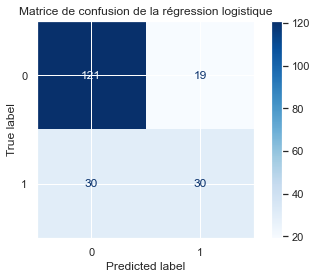

In [3]:
title = 'Matrice de confusion de la régression logistique'
disp = plot_confusion_matrix(logreg,
                             X_test,
                             y_test,
                             cmap=plt.cm.Blues)
ax = disp.ax_.set_title(title)
plt.show()

Dans cette représentation on a :
 - Vrai positif : bas à droite
 - Faux positif : haut à droite
 - Vrai négatif : haut à gauche
 - Faut négatif : bas à droite

---
[MOD]

## Étude de cas 

Prenons le cas de figure suivant : la banque allemande qui utilise le modèle de régression logistique pour accepter ou refuser les prêts veut vérifier si son modèle respecte certaine définition d'équité.
Elle choisie de définir que son modèle est juste si les hommes et les femmes sont traité de la même manière. 

La variable sensible est donc `sex`.

Il faut ensuite  choisir la métrique à optimiser mais dans un premier temps commençons par utiliser la librairie *AI Fairness 360*.

### Mise en place
---

La manière dont *AIF360* fonctionne pour le calcul de métrique de parité est la suivante :
 - On crée un dataframe `results` qui contient le $Y$, $\hat{Y}$ et la variable sensible en binaire
 - On utilise l'objet BinaryLabelDataset en précisant le label et la variable sensible. On construit un objet de ce type pour les prédictions et un autre objet pour les tests.
  - On utilise ensuite l'objet *ClassificationMetric* qui prend en entrée deux *BinaryLabelDataset* et une classification des groupes privilégiés. Cet objet permet de calculer un très grand nombre de métriques énoncées à l'adresse ([liste](https://aif360.readthedocs.io/en/latest/modules/sklearn.html#module-aif360.sklearn.metrics)).

In [4]:
def model2fair(modelf, X_test, y_test, col=X.columns):
    y_test_df = pd.Series(y_test, index=X_test.index, name='default')
    y_pred_df = pd.Series(modelf.predict(X_test[col]), 
                          index=X_test.index, name='default')
    
    sex_bin = X_test.sex.map({'male': 0, 'female': 1})

    results_test = pd.concat([y_test_df, sex_bin], axis=1)
    results_pred = pd.concat([y_pred_df, sex_bin], axis=1)
    
    bld_test = BinaryLabelDataset(df=results_test,
                                  label_names=['default'], 
                                  protected_attribute_names=['sex'])

    bld_pred = BinaryLabelDataset(df=results_pred,
                                  label_names=['default'], 
                                  protected_attribute_names=['sex'])
    
    fairness_metrics = ClassificationMetric(bld_test, bld_pred, 
                                        unprivileged_groups=[{'sex': 1}],
                                        privileged_groups=[{'sex': 0}])
    return fairness_metrics, (bld_test, bld_pred)

In [5]:
fairness_metrics, (bld_test, bld_pred) = model2fair(logreg, X_test, y_test)

---
[MOD]

On a finalement l'objet `fairness_metrics`, reste encore à choisir la métrique à optimisée.

### Choix de la mesure

En suivant l'arbre d'*Aequitas* un des chemins possible est :

**Voulez-vous être équitable sur la base d'une représentation hétérogène ou sur la base d'erreurs hétérogène de votre système ?**

Ici on cherche à traiter les personnes indépendement de leur sexe, on veut être équitable sur la base d'erreurs hétérogène.
 
**Faites-vous confiance aux labels ?**

Ici on a pas de raison de douter sur la falsification de la variable `sex`.

**Votre intervention est-elle punitive ou positive ?**

Ici le résultat est le refus du prêt donc l'intervention est punitive.

**Dans quel groupe êtes-vous le plus soucieux d'assurer l'équité ?**

C'est ici que le choix de la métrique dépend de la position dans laquelle on est. Soit on est un emprunteur potentielle et ne souhaite pas l'intervention (être classifier comme 1) donc on veut maximiser l'équité de la *False Positive Rate*. Soit on se place du côté du banquier et on souhaite que les personnes refusé à tord soit équitablement répartie selon le sexe donc on maximiser l'équité de *False Discovery Rate*.

On voit déjà que le choix de définition de l'équité est très importante à prendre en compte et on verra par la suite les implications.

Mesurons dans un premier temps les différentes métriques.

#### False Positive Rate Ratio

Pour s'assurer de l'équité de la *False Positive Rate* on utilise le ratio des faux positif.

Cette mesure est définie comme :
$$
\frac{\mathbb{P}(\hat{Y} = 1 \mid {D = \text{unprivileged}, Y=0})}{\mathbb{P}(\hat{Y} = 1 \mid {D = \text{privileged}, Y=0})}
$$
Elle correspond au ratio de la probabilité d'être prédit comme incapable de rembourser alors qu'on en était capable entre les femmes et les hommes. Une valeur de 1 veut dire que les hommes et les femmes bons payeurs ont autant de chance de se faire prédire comme mauvais payeur.

---

In [6]:
fprr = fairness_metrics.false_positive_rate_ratio()
print(f'False Positive Rate Ratio : {fprr:.2f}')

False Positive Rate Ratio : 2.78


---
[MOD]

On voit que le ratio est de 2,78 donc les femmes bonnes payeuses on 2,78 fois plus de chance de se faire refuser un prêt que les hommes bons payeurs.

#### False Discovery Rate Ratio

De la même manière pour s'assurer de l'équité de la *False Discovery Rate* on utilise le ratio.

Cette mesure est définie comme : 
$$
\frac{\mathbb{P}(Y = 0 \mid {D = \text{unprivileged}, \hat{Y}=1})}{\mathbb{P}(Y = 0 \mid {D = \text{privileged}, \hat{Y}=1})}
$$
Elle correspond au ratio de la probabilité d'être un bon payeur alors que l'on a été prédit comme mauvais payeur étant une femme sur celle étant un homme. Une valeur de 1 assure qu'il y a équité.

---

In [7]:
fpdr = fairness_metrics.false_discovery_rate_ratio()
print(f'False Discovery Rate Ratio : {fpdr:.2f}')

False Discovery Rate Ratio : 1.16


---
[MOD]

Selon cette mesure le modèle est déjà plus équitable avec les femmes bonnes payeuse qui n'ont que 1,16 fois plus chance que les hommes bon payeur d'être prédit comme mauvais payeur.

Dans tout les cas on voit que le sexe de l'individu qui demande un prêt joue un rôle sur la possibilité de se le voir accorder. Or tout comme l'ethnicité ou la religion, il est interdit en France de discriminé selon cette variable. On va voir les différentes méthodes possible pour rétablir l'équité.

## Retrouver l'équité

La première méthode naïve est de retirer la variable sensible du jeu de donnée et d'entraîné le modèle sans qui n'ai connaissance de celle-ci.

---

In [8]:
# create a new model that does not take `sex` variable
col_nosex = [column for column in X.columns if column != ["sex"]]
X_nosex = X[col_nosex]

# class the variable between categorical and ordinal 
cat_variables = [col for col in X_nosex.columns if credit[col].dtype==object]
ord_variables = [col for col in X_nosex.columns if credit[col].dtype==int]

preprocess_nosex = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_variables),
        ('ord', StandardScaler(), ord_variables)
    ])

model_nosex = Pipeline(
        [
            ('prepro', preprocess_nosex),
            ('logreg', LogisticRegression())
        ]
)

# new model that train without `sex` variable
logreg_nosex = deepcopy(model_nosex.fit(X_train[col_nosex], y_train))

# new metrics
fairness_metrics_nosex, _ = model2fair(logreg_nosex, X_test, y_test, col_nosex)

In [9]:
fprr = fairness_metrics_nosex.false_positive_rate_ratio()
print(f'False Positive Rate Ratio : {fprr:.2f}')

False Positive Rate Ratio : 2.78


In [10]:
fpdr = fairness_metrics_nosex.false_discovery_rate_ratio()
print(f'False Discovery Rate Ratio : {fpdr:.2f}')

False Discovery Rate Ratio : 1.16


---
[MOD]

Retirer la variable `sex` de la base de donnée d'entraînement n'a pas modifié les métriques. On doit donc utiliser des méthodes plus complexe qui sont proposées dans la libraire *AIF60*.

---

---
[MOD]

### Présentation des trois grandes familles 

Les méthodes d'aborder les problèmes d'équité se découpe en trois familles qui correspondent à trois moments de la conception d'un modèle.

![](data/imgs/familles_fairness.png)

#### Pre-Processing

Les méthodes pre-processing sont des méthodes agnostic visent à traité les problèmes d'équité avant même que les données soit utilisées pour entraîner un modèle en transformant une ou plusieurs variables. 

#### In-Processing

Ces méthodes implémentent une ou plusieurs mesures directement dans le processus d'entraînement. Ces méthodes sont souvent assez généraliste dans leur énoncé mais leur implémentation dépend du modèle choisi.

#### Post-processing

Ces méthodes sont comme les méthodes pre processing n'ont pas besoin d'avoir accès au modèle pour les mettre en place. Mais au lieu de se concentrer sur les données en amont, ces méthodes traitent les problèmes d'équité sur les prédictions du modèle.

---

---
[MOD]

### Implémentation de la méthode

#### *Reweight*

La méthode que l'on va utilisé est une méthode de *pre-processing*. Cette méthode ne dépends donc pas du modèle choisi.

Le principe est le suivant, on va affecter un poids à chaque groupe (individu, label) pour s'assurer de l'équité en tirant équitablement les individus des différents groupe. 

---

In [244]:
def reweight_weight(y_train):
    rw = Reweighing(unprivileged_groups=[{'sex': 1}], 
                    privileged_groups=[{'sex': 0}])

    sex_bin_df = pd.DataFrame(X_train.sex.map({'male': 0, 'female': 1}), 
                              columns=['sex'])
    bld_train = BinaryLabelDataset(df=pd.concat([sex_bin_df, y_train], axis=1),
                                                    label_names=['default'], 
                                                    protected_attribute_names=['sex'])
    bld_train = rw.fit_transform(bld_train)
    
    return bld_train.instance_weights.ravel()

In [243]:
w_train = reweight_weight(y_train)
logreg_rw = deepcopy(model.fit(X_train, y_train, logreg__sample_weight = w_train))

fairness_metrics_rw, _ = model2fair(logreg_rw, X_test, y_test)

In [241]:
fprr_rw = fairness_metrics_rw.false_positive_rate_ratio()
print(f'False Positive Rate Ratio : {fprr_rw:.2f}')
print(f'Gain : {(fprr - fprr_rw)/fprr:.2f}')

False Positive Rate Ratio : 1.88
Gain : 0.32


In [242]:
fpdr_rw = fairness_metrics_rw.false_discovery_rate_ratio()
print(f'False Discovery Rate Ratio : {fpdr_rw:.2f}')
print(f'Gain : {(fpdr - fpdr_rw)/fpdr:.2f}')

False Discovery Rate Ratio : 1.04
Gain : 0.19


---
[MOD]

On observe donc une nette amélioration des différentes métriques. Juste en tirant équitablement les individus on a réduit de 30% les inégalités selon la *false positive rate* et de 10% pour la *false discovery rate*. 

Pour mieux comprendre l'effet de discrimination on créer des bases de données biaisées de deux façons différentes :
 - la demande de prêt est facilité pour les hommes (on change les 1 en 0 pour une fraction de la population masculine)
 - la demande de prêt est plus difficile pour les femmes (on change les 0 en 1 pour une fraction de la population femminine)

On observe ensuite la manière dont évolu la performance du modèle, les métriques d'équité, le gain pour chacunes des métriques et la perte de performance avant et après l'application du *reweighting*.

---

In [300]:
def bias_train(frac, sex):
    if sex == 'male':
        label = 1
    else:
        label = 0
        
    y_train_subset = y_train[X_train.sex == sex]
    index_subset_label = y_train_subset[y_train_subset == label].index
    
    size=int(frac*len(index_subset_label))
    change_idx = np.random.choice(index_subset_label, size=size, replace=False)
    
    y_train_mod = deepcopy(y_train)
    y_train_mod[change_idx] = 1 - label
    
    return y_train_mod

In [359]:
columns = ['sex', 'bias', 'fppr', 'fpdr', 'fppr_rw', 
           'fpdr_rw', 'accuracy', 'accuracy_rw']
n_test = 100

if NEW:
    df_fair = pd.DataFrame(columns=columns)

    for sex in ['male', 'female']:
        for frac in tqdm(np.linspace(0, 1, 20)):
            for _ in range(n_test):
                y_train_mod = bias_train(frac, sex)

                logreg_bias = model.fit(X_train, y_train_mod)
                fairness_bias, _ = model2fair(logreg_bias, X_test, y_test)

                w_train_mod = reweight_weight(y_train_mod)
                logreg_bias_rw = model.fit(X_train, y_train_mod, 
                                           logreg__sample_weight = w_train_mod)

                fairness_bias_rw, _ = model2fair(logreg_bias_rw, X_test, y_test)

                res = {'sex': sex,
                       'bias': frac,
                       'fppr': fairness_bias.false_positive_rate_ratio(),
                       'fpdr': fairness_bias.false_discovery_rate_ratio(),
                       'fppr_rw': fairness_bias_rw.false_positive_rate_ratio(),
                       'fpdr_rw': fairness_bias_rw.false_discovery_rate_ratio(),
                       'accuracy': fairness_bias.accuracy(),
                       'accuracy_rw': fairness_bias_rw.accuracy()}

                df_fair = df_fair.append(res, ignore_index=True)
                
                np.savez_compressed(f'data/fairness/res_reweight.npz', 
                        df_fair=df_fair)
else:
    file = np.load('data/fairness/res_reweight.npz', allow_pickle=True)
    df_fair = pd.DataFrame(file['df_fair'], columns=columns)
    
df_fair['accuracy_diff'] = df_fair['accuracy'] - df_fair['accuracy_rw']
df_fair['fppr_gain'] = (df_fair['fppr'] - df_fair['fppr_rw']) / df_fair['fppr']
df_fair['fpdr_gain'] = (df_fair['fpdr'] - df_fair['fpdr_rw']) / df_fair['fpdr']

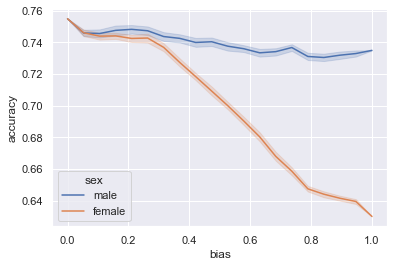

In [365]:
sns.lineplot(x='bias', y='accuracy', data=df_fair, hue='sex')
plt.show()

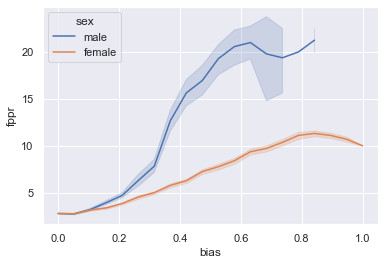

In [366]:
sns.lineplot(x='bias', y='fppr', data=df_fair, hue='sex')
plt.show()

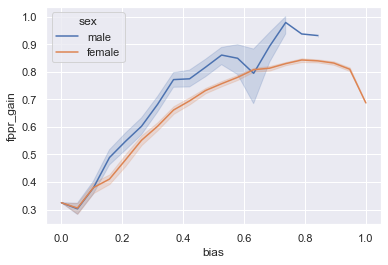

In [364]:
sns.lineplot(x='bias', y='fppr_gain', data=df_fair, hue='sex')
plt.show()

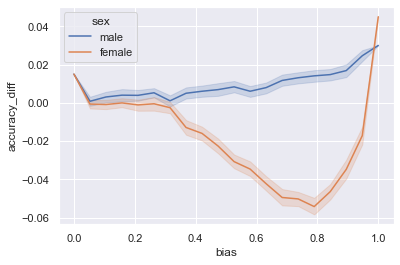

In [360]:
sns.lineplot(x='bias', y='accuracy_diff', data=df_fair, hue='sex')
plt.show()

---
[MOD] [PAS TERMINER]



Pour aller plus loin il faut implémenter des méthodes in et post processing qui permettront de réduire encore les inégalités.

---

# Partie 3

## Les librairies d’équité ne sont pas assez matures

Contrairement au deux autres notions, les librairies d’équité sont plus nombreuses :
 - *What-If-Tool* développé par Google depuis 2019 
 - *AI Fairness 360* développé par IBM depuis 2018 
 - *Fair-learn* développé par Microsoft depuis 2019 
 - *Aequitas* développé par *Center for Data Science and Public Policy* (Université de Chicago) depuis 2018

De plus, les librairies ne sont pas uniquement des libraires d’implémentation de méthodes.par exemple, *What-If-Tool* et *Aequitas* proposent des outils de visualisation des impacts de l’équité. Il n’est plus question uniquement de mettre en place des solutions mais également de sensibiliser sur les risques potentiels. Les méthodes pour mitiger ces risques ne sont cette fois-ci pas autant poussées sur les modèles d’apprentissage profonds et par exemple il n’existe pas de méthodes de débiaisage pour les modèles de vision ou de langages, deux secteurs où le risque de discrimination de certains groupes pourraient avoir de grandes conséquences. Pour ce qui est des métriques, des librairies comme *AI Fairness 360* propose des outils très simples pour les calculer. Mais n’étant pas encore utiliser de manière importante les objets qui sont demandés d'utiliser pour faciliter le calcul des métriques ne sont pas très bien détaillés. Les échanges sur les sites comme *stack overflow* montre le manque de retour, on peut voir qu’il y a des dizaines de questions sur l’outil de Google mais encore très peu pour les autres libraires. 
Il est nécessaire de continuer de simplifier les outils et de créer des visualisations des enjeux. Les librairies d’équités peuvent ainsi être un exemple pour les librairies des autres enjeux car elles sont plus matures. Contrairement aux deux autres, de nouvelles méthodes pour des modèles d’apprentissage profond  attendent d’être développées. On peut également attendre un plus grand nombre d’échanges sur les sites d'entraide, échanges qui se feront lorsque le nombre d’utilisateurs de tels outils augmentera.
Pour en arriver là il est important de démocratiser et de normaliser des outils comme *What-If-Tool* pour que son utilisation ne soit pas cantonné à des modèles implémentés avec la librairie d’apprentissage de Google *Tensor Flow*.

## Les librairies pour l’équité ne sont pas assez adaptées aux industriels
Grâce aux outils de visualisation et le nombre important de méthodes développées pour des modèles plus simples, les librairies d’équité sont les librairies les plus adaptées aux industriels en comparaison à celles de privacy et robustness. Néanmoins le nombre de métriques et de méthodes de débiaisage différentes rend difficile le choix de celle la plus pertinente. Comme on ne peut pas optimiser tous les critères d'équité il est très important de choisir la métrique permettant l’optimisation des critères que l’on souhaite prioriser, cette métrique dépendant du problème étudié. Pour aider à ce choix, des documents comme l’arbre ci-dessous existent. Malgré tout, cela reste une version simplifiée des choix possibles qui nécessite de la part du développeur de connaître très précisément le problème étudié pour le ranger dans l’une des classes proposées par l’arbre. Ce choix de classe est une tâche compliquée pour ce dernier.  
Il est aussi important de souligner que la majorité des méthodes implémentées se base sur l'existence de deux choses: une variable sensible accessible et des groupes avantagés/discriminés. Or l'existence de cette variable n’est pas une hypothèse tenable car, de plus en plus, les réglementations comme la RGPD empêchent le stockage de la plupart des variables que l’on pourrait considérer comme sensibles. Par ailleurs, ne pas connaitre le sexe ou l’ethinicté d’une personne ne veut pas dire que le modèle ne sera pas disciminant et malgré le retrait des variables dites sensibles, le modèle peut rester inégalitaire. Il est donc nécessaire de trouver une solution à la mesure de l’équité tout en respectant les données des utilisateurs. 
Afin de rendre l’utilisation de ces méthodes encore plus populaire, ces dernières doivent faire partie des outils de autoML, les implémentations se faisant in-processing (durant l'entraînement). Continuer à produire des documents de communication permettrait également de sensibiliser les utilisateurs car la compréhension des métriques d’équité est fondamentale pour comprendre les enjeux d’un modèle.

## Il existe un arbitrage entre performance et équité

Peu importe le moment où on implémente les méthodes d'équité (pre, in, post-processing) celles-ci auront nécessairement un impact sur les performances du modèle. L’implémentation des différentes méthodes sur l’exemple nous le montre avec une biasse de l’*accuracy* lorsque l’on rajoute une méthode. Il existe donc un compromis entre la précision du modèle et son équité. De même, tout ajout de méthodes implique des temps de calcul plus long pour la majorité des méthodes existantes. Mais ces compromis ne sont pas uniquement entre deux notions distinctes, comme nous le montre https://arxiv.org/abs/1609.05807, il existe un compromis intrinsèque à la notion d’équité que l’on cherche à obtenir. Pour illustrer ce dernier point, nous allons prendre l’exemple du papier ci-dessus : en cherchant un modèle  pour déterminer la probabilité d’un individu de contracter une maladie. Le papier démontre que, pour la base de donnée considérée, l’une de ces trois propriétés sera vraie pour n’importe quel modèle utilisé :
 - les estimations de probabilité du test sont systématiquement faussées vers le haut ou vers le bas pour au moins un sexe
 - le test attribue une estimation du risque moyen plus élevée aux personnes en bonne santé (non porteuses) d'un sexe que de l'autre
 - le test attribue une estimation du risque moyen plus élevée aux porteurs de la maladie d'un sexe par rapport à l'autre.

Comprendre les arbitrages afin de faire les choix judicieux est donc très important pour une bonne implémentation des modèles. On voit ainsi le besoin d’exemples comme celui ci-dessus dans des secteurs diversifiés et la nécessité de supports pour aider les industries à comprendre les enjeux et les arbitrages nécessaires. 
